In [627]:
# Diabetes Progression Prediction Model

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import pprint
from sklearn.feature_selection import SelectKBest, f_regression
from tabulate import tabulate

# Random seed for reproducibility
np.random.seed(42)

## LOAD THE DIABETES DATASET

In [628]:
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (442, 10)
Target shape: (442,)


### 2. Problem Statement

Using Scikit-Learn Diabetes dataset. The objective is to build a model that can best predict the risk of diabetes progression in one year.

The dependent variable is "disease progression one year after baseline", 
this is a continuous value. Therefore, therefore we can use regression to predict the value of the dependant variable in the testing dataset

### 3. Exploratory Data Analysis

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: progression, dtype: float64
count    4.420000e+02
mean     1.230790e-17
std      4.761905e-02
min     -4.464164e-02
25%     -4.464164e-02
50%     -4.464164e-02
75%      5.068012e-02
max      5.068012e-02
Name: sex, dtype: float64
count    4.420000e+02
mean    -2.245564e-16
std      4.761905e-02
min     -9.027530e-02
25%     -3.422907e-02
50%     -7.283766e-03
75%      3.124802e-02
max      1.705552e-01
Name: bmi, dtype: float64


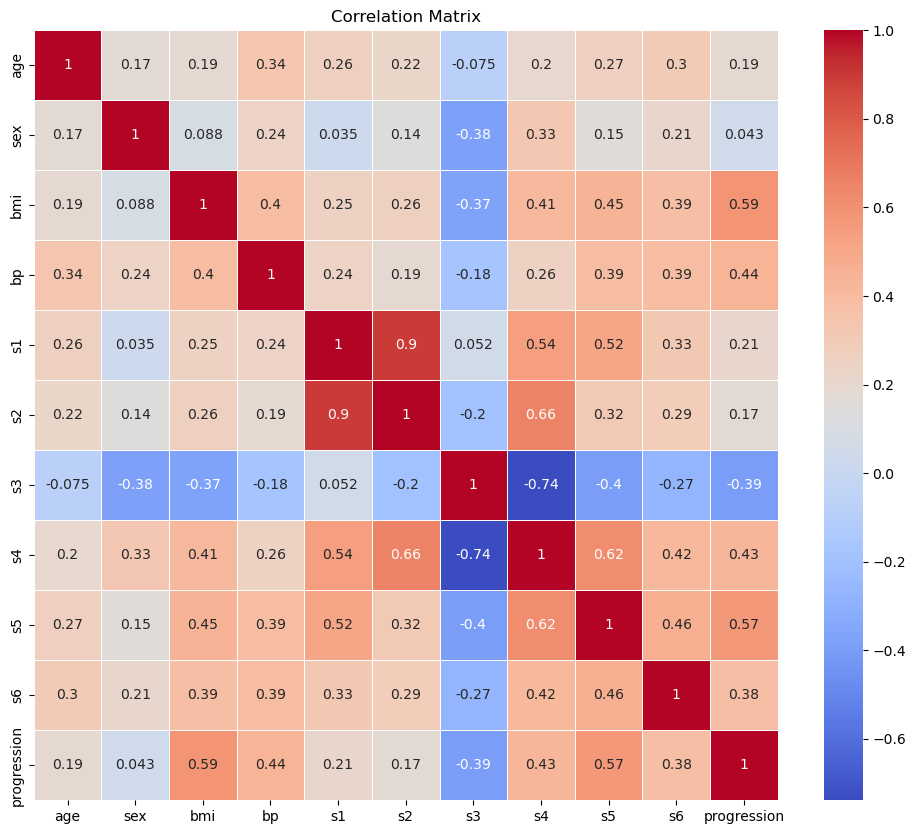

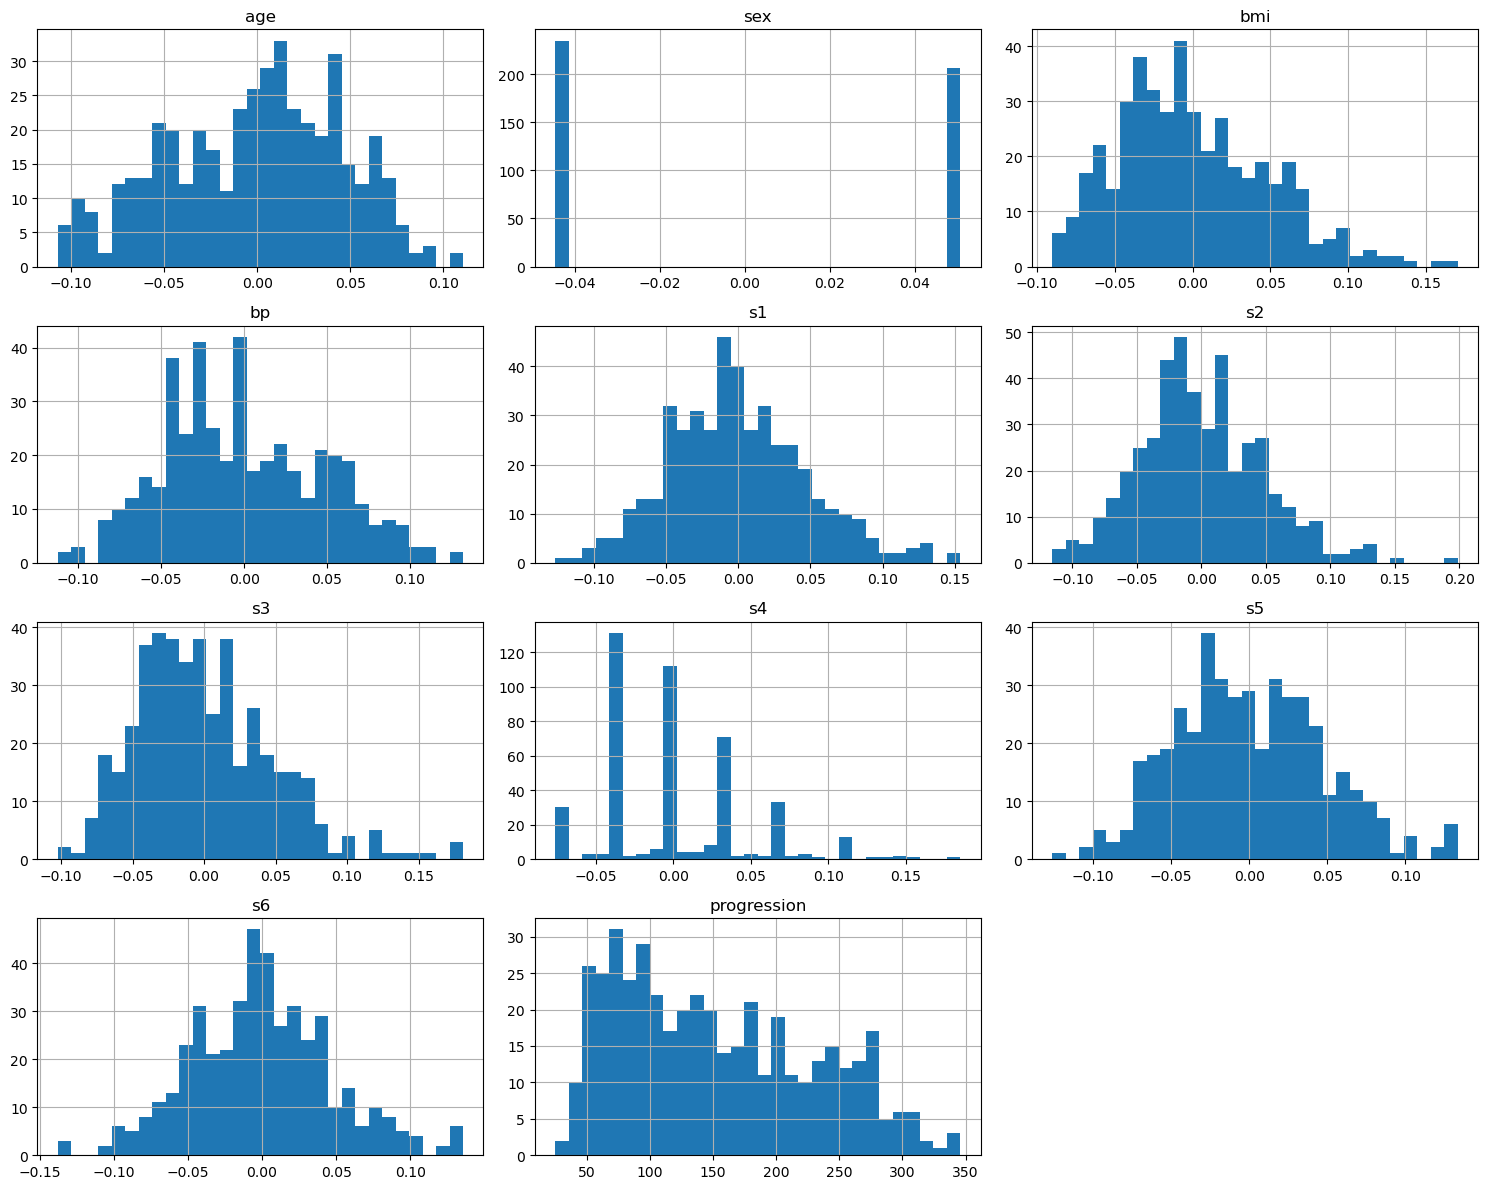

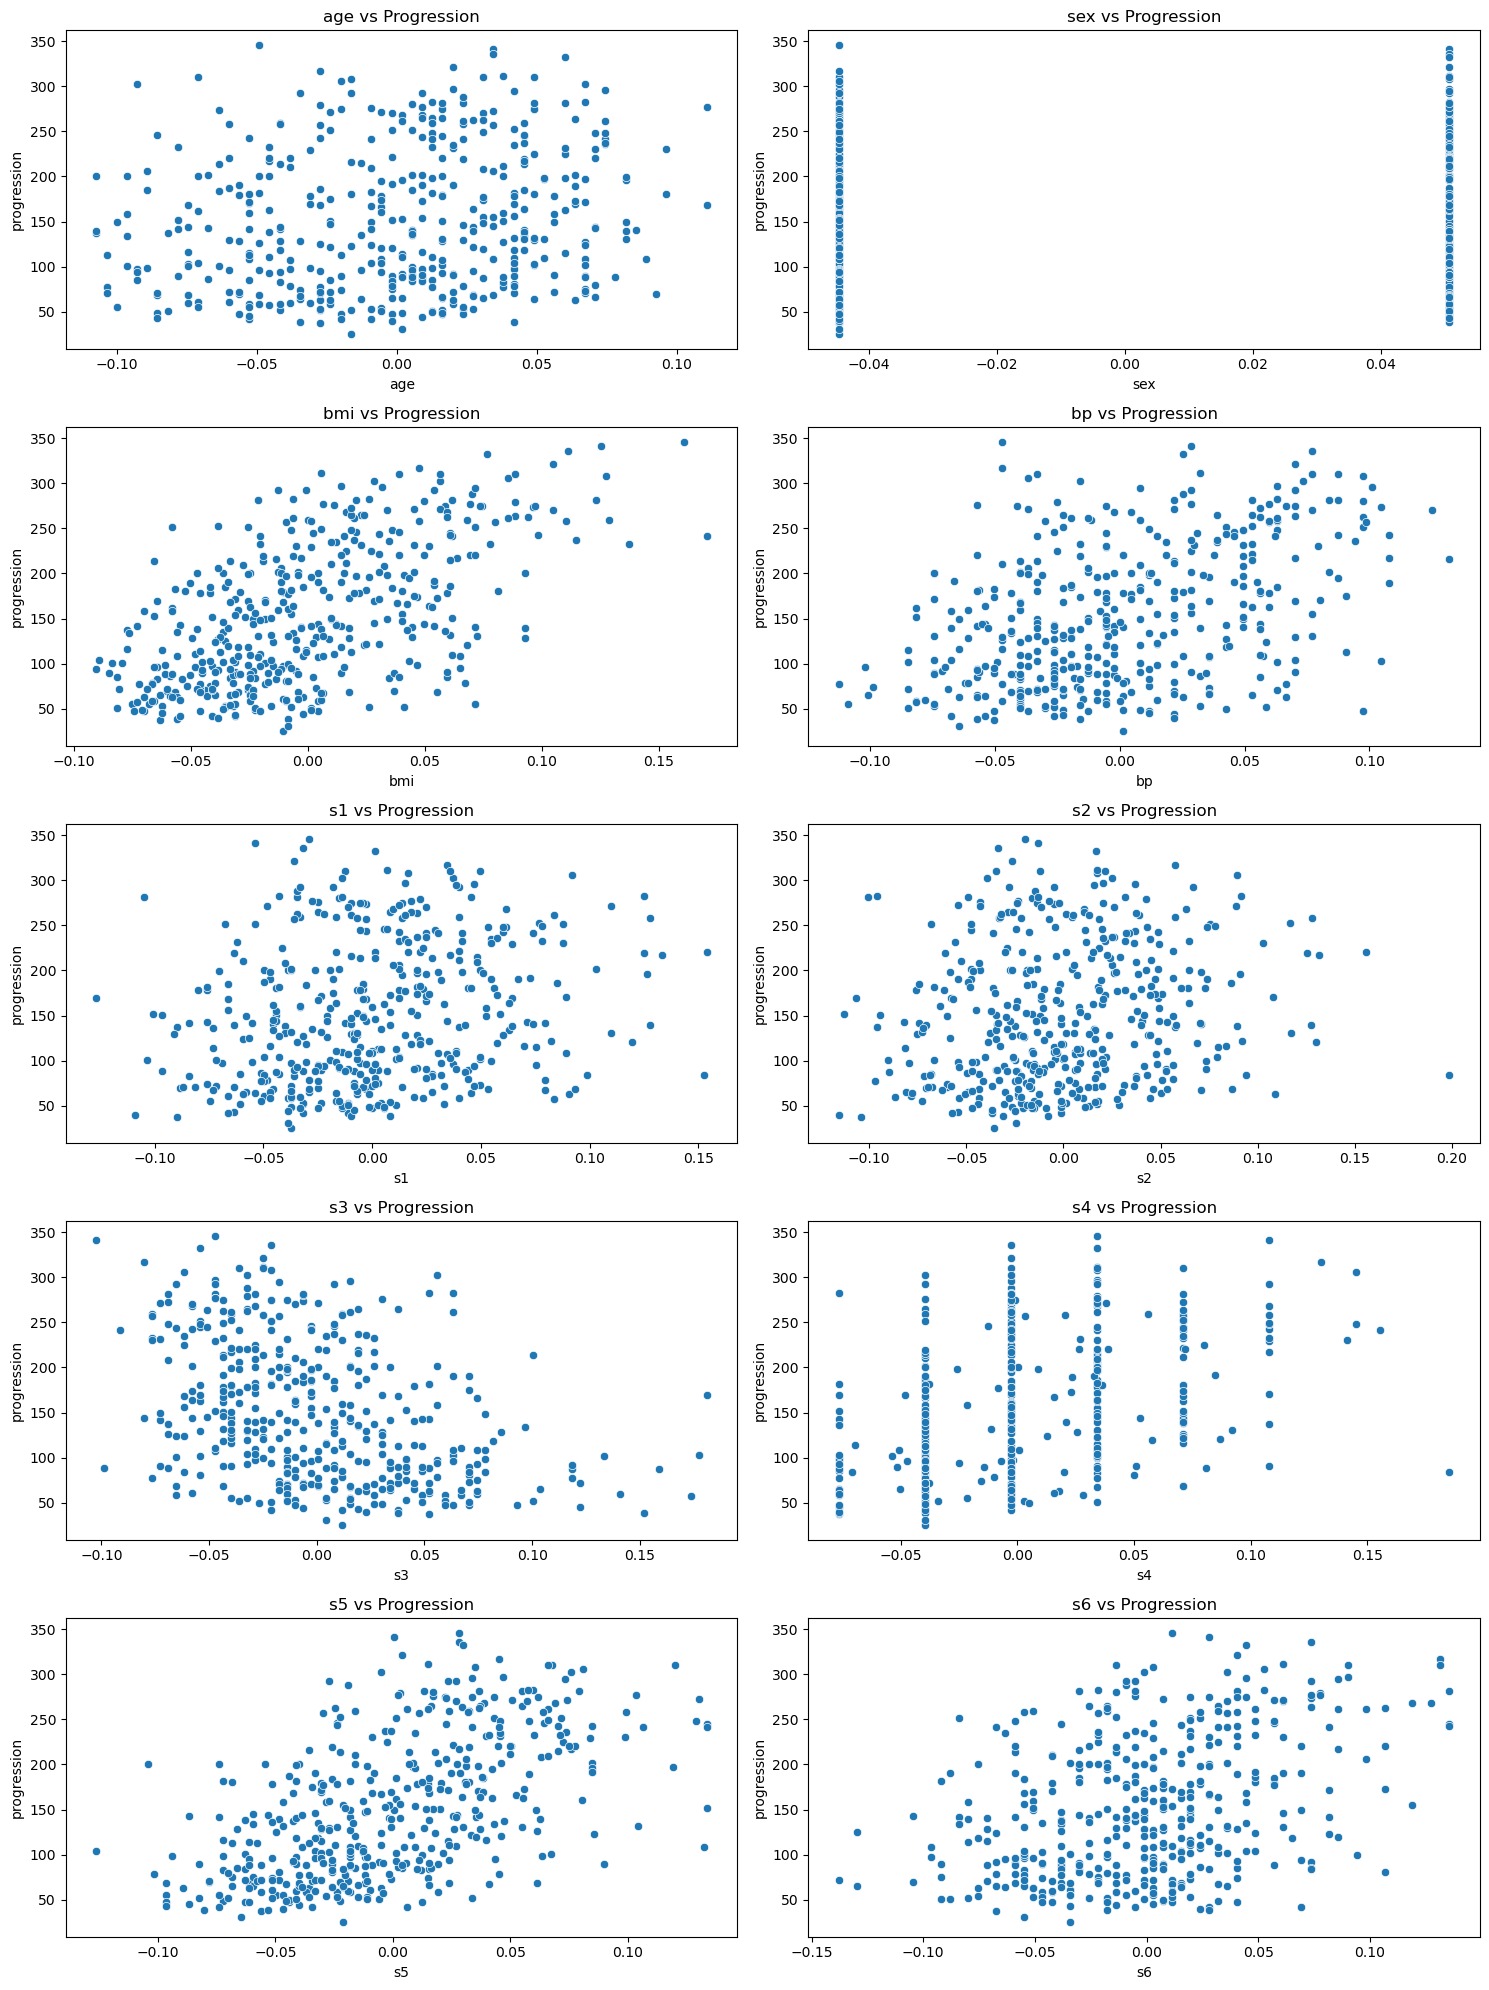

In [629]:
# Create the dataframe containing the features and the target column
df = X.copy()
df['progression'] = y
print(df['progression'].describe())
print(df['sex'].describe())
print(df['bmi'].describe())

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Histograms
df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

# Scatter plot feature vs progression
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.ravel()

for i, col in enumerate(X.columns):
    sns.scatterplot(data=df, x=col, y='progression', ax=axes[i])
    axes[i].set_title(f'{col} vs Progression')

plt.tight_layout()
plt.show()

# Insights
- The target variable 'progression' ranges from 25 to 346.

- The feature with the highest correlation to progression is BMI. Second highest being s5 (log of serum triglycerides level)

- The features show a non-linear relationship with "progression", therefore using polynomial regression here is an appropriate choice.

- The data is already scaled. Including the "sex" feature. So we can use the features without further pre-processing

"Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1)."
- https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

In [630]:
# Splitting data into Train, test and validate sets.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# At this point X_temp is the training set at 85% and the test set contains 15%
# We need to further split the train set to be 75% and leave a validation set of 10%

# 0.1176×85% = ≈10%
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1176, random_state=42)

print("\nData Split Sizes:")
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Data Split Sizes:
Train set: 330 samples
Validation set: 45 samples
Test set: 67 samples


- Training set is now 75%
- Test set is now 15%
- Validation set is now 10%

In [631]:
def evaluate_model(y_true, y_pred):
    return {
        'R-squared': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

In [632]:
def display_results_table(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    train_scores = evaluate_model(y_train, train_pred)
    val_scores = evaluate_model(y_val, val_pred)
    test_scores = evaluate_model(y_test, test_pred)
    
    table_data = [
        ["Metric", "Train", "Validation", "Test"],
        ["R-squared", f"{train_scores['R-squared']:.4f}", f"{val_scores['R-squared']:.4f}", f"{test_scores['R-squared']:.4f}"],
        ["MAE", f"{train_scores['MAE']:.4f}", f"{val_scores['MAE']:.4f}", f"{test_scores['MAE']:.4f}"],
        ["MAPE", f"{train_scores['MAPE']:.4f}", f"{val_scores['MAPE']:.4f}", f"{test_scores['MAPE']:.4f}"]
    ]
    
    print(f"\n{model_name} Results:")
    print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

# 6. Univariate Polynomial Regression Models

In [633]:
def create_poly_features(X, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    return poly.fit_transform(X.reshape(-1, 1))

# THE MODEL EXPECTS MULTIPLE FEATURES SO WE CONVERT THE 1D array to a 2D array with only 1 column -> [[x,x2,x3]]
bmi_train = X_train['bmi'].values.reshape(-1, 1)
bmi_val = X_val['bmi'].values.reshape(-1, 1)
bmi_test = X_test['bmi'].values.reshape(-1, 1)

results = []
for degree in [0,1, 2, 3, 4, 5]:
    X_poly_train = create_poly_features(bmi_train, degree)
    X_poly_val = create_poly_features(bmi_val, degree)
    X_poly_test = create_poly_features(bmi_test, degree)
    
    model = LinearRegression()
    display_results_table(model, X_poly_train, y_train, X_poly_val, y_val, X_poly_test, y_test, f"Polynomial (degree {degree})")


Polynomial (degree 0) Results:
+-----------+---------+--------------+---------+
| Metric    |   Train |   Validation |    Test |
+===========+=========+==============+=========+
| R-squared |  0      |      -0      | -0.007  |
+-----------+---------+--------------+---------+
| MAE       | 66.5482 |      63.4475 | 64.1703 |
+-----------+---------+--------------+---------+
| MAPE      |  0.6335 |       0.5879 |  0.6122 |
+-----------+---------+--------------+---------+

Polynomial (degree 1) Results:
+-----------+---------+--------------+---------+
| Metric    |   Train |   Validation |    Test |
+===========+=========+==============+=========+
| R-squared |  0.3542 |       0.4493 |  0.2038 |
+-----------+---------+--------------+---------+
| MAE       | 52.2781 |      41.9976 | 54.9337 |
+-----------+---------+--------------+---------+
| MAPE      |  0.4846 |       0.4044 |  0.4875 |
+-----------+---------+--------------+---------+

Polynomial (degree 2) Results:
+-----------+---------

# Univariate polynomial regression on the BMI feature versus the "disease progression one year after baseline" - from degree 0 to 5


We don't consider the model with degree 0 because all the data points would be transformed to '1', because anything to the power of zero is 1. Which would make our predictions unusable for the model. 

- Normally it would throw an error if we tried to run regression with degree 0, because the output array will be empty
- In this code block it does not throw an error when we use degree 0 only because we are using a bias term.
- This mean that the model with degree 0 will only calculate the bias term (intercept) and not the relationship between the feature and dependant variable.
- Considering the above points, ideally we should not run the model with degree 0 at all.

# Choosing the best model

- On average we can see that the fit is improving as we increase the degree.

- Degree 4 has the lowest MAPE, indicating that it is performing the most accurate predictions on average.

- The R square value of degree 5 is the highest, but the MAE and MAPE of that model are slightly worse than degree 4.

- This could indicate that the model with degree 5 has slightly overfitted the data as compared to degree 4, due to degree 4 having a better MAE and MAPE though it has a lower r square value.

# Degree 4 will be chosen as our best model, we will now run the model with degree 4 on the test dataset.

In [634]:
chosen_best_model = 4
best_model = LinearRegression()
X_poly_train = create_poly_features(bmi_train, chosen_best_model)
X_poly_test = create_poly_features(bmi_test, chosen_best_model)
best_model.fit(X_poly_train, y_train)
y_pred_test = best_model.predict(X_poly_test)
test_scores = evaluate_model(y_test, y_pred_test)

print("\nTest Set Performance:")
for metric, value in test_scores.items():
    print(f"  {metric}: {value:.4f}")


Test Set Performance:
  R-squared: 0.1698
  MAE: 55.0090
  MAPE: 0.4815


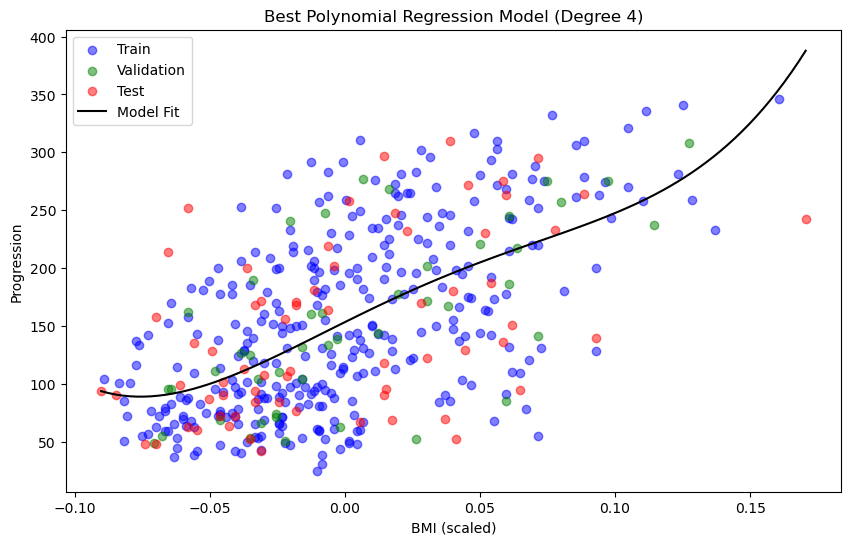

In [635]:
plt.figure(figsize=(10, 6))
plt.scatter(bmi_train, y_train, color='blue', alpha=0.5, label='Train')
plt.scatter(bmi_val, y_val, color='green', alpha=0.5, label='Validation')
plt.scatter(bmi_test, y_test, color='red', alpha=0.5, label='Test')

X_plot = np.linspace(X['bmi'].min(), X['bmi'].max(), 100).reshape(-1, 1)
X_poly_plot = create_poly_features(X_plot, chosen_best_model)
y_plot = best_model.predict(X_poly_plot)

plt.plot(X_plot, y_plot, color='black', label='Model Fit')
plt.xlabel('BMI (scaled)')
plt.ylabel('Progression')
plt.title(f'Best Polynomial Regression Model (Degree {chosen_best_model})')
plt.legend()
plt.show()

In [636]:
coefficients = best_model.coef_
intercept = best_model.intercept_

equation = f"y = {intercept:.2f}"
for i, coef in enumerate(coefficients):
    equation += f" + {coef:.2f} * x^{i+1}"

print("\nModel Equation:")
print(equation)


Model Equation:
y = 153.38 + 0.00 * x^1 + 1157.17 * x^2 + -1200.89 * x^3 + -43541.35 * x^4 + 340316.81 * x^5


# Calculate the expected diabetes progression for a BMI value of your choice using `model.predict()` for that value 

In [637]:

chosen_bmi = 0.02  # scaled BMI value
X_chosen = create_poly_features(np.array([[chosen_bmi]]), chosen_best_model)
predicted_progression = best_model.predict(X_chosen)[0]

print(f"\nFor a scaled BMI value of {chosen_bmi}, the predicted diabetes progression is: {predicted_progression:.2f}")



For a scaled BMI value of 0.02, the predicted diabetes progression is: 175.75


# How many trainable parameters are we fitting for each of the models?

In [638]:
for degree in range(6):
    params = degree + 1  # degree + intercept
    print(f"Degree {degree} polynomial: {params} trainable parameters")
    poly = PolynomialFeatures(degree=degree)
    poly.fit(np.array([[0]]))
    feature_names = poly.get_feature_names_out(input_features=['x'])
    print("Feature Names:", feature_names)
    print('\n')

Degree 0 polynomial: 1 trainable parameters
Feature Names: ['1']


Degree 1 polynomial: 2 trainable parameters
Feature Names: ['1' 'x']


Degree 2 polynomial: 3 trainable parameters
Feature Names: ['1' 'x' 'x^2']


Degree 3 polynomial: 4 trainable parameters
Feature Names: ['1' 'x' 'x^2' 'x^3']


Degree 4 polynomial: 5 trainable parameters
Feature Names: ['1' 'x' 'x^2' 'x^3' 'x^4']


Degree 5 polynomial: 6 trainable parameters
Feature Names: ['1' 'x' 'x^2' 'x^3' 'x^4' 'x^5']




- For a polynomial regression model of degree n, there exist n+1 parameters
- n number of parameters will be coefficients
- we add +1 parameter to account for the intercept
- that gives us n+1 params

In [639]:
def select_features(X, y, k=5):
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    return selected_features

selected_features = select_features(X_train, y_train)
print("Selected features:", selected_features)

Selected features: ['bmi', 'bp', 's4', 's5', 's6']


# We use SelectKBest to select the top 5 features according to the scores.

In [640]:
# Polynomial Models
for degree in [1,2]:
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X_poly_train = poly.fit_transform(X_train[selected_features])
    X_poly_val = poly.transform(X_val[selected_features])
    X_poly_test = poly.transform(X_test[selected_features])
    
    model = LinearRegression()
    display_results_table(model, X_poly_train, y_train, X_poly_val, y_val, X_poly_test, y_test, f"Polynomial (degree {degree})")

# Decision Trees
for max_depth in [4,5]:
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    display_results_table(model, X_train[selected_features], y_train, X_val[selected_features], y_val, X_test[selected_features], y_test, f"Decision Tree (max_depth={max_depth})")

# k-Nearest Neighbors
for n_neighbors in [10,11]:
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    display_results_table(model, X_train[selected_features], y_train, X_val[selected_features], y_val, X_test[selected_features], y_test, f"KNN (n_neighbors={n_neighbors})")


Polynomial (degree 1) Results:
+-----------+---------+--------------+---------+
| Metric    |   Train |   Validation |    Test |
+===========+=========+==============+=========+
| R-squared |  0.4747 |       0.5869 |  0.433  |
+-----------+---------+--------------+---------+
| MAE       | 47.0037 |      38.8494 | 45.0261 |
+-----------+---------+--------------+---------+
| MAPE      |  0.4198 |       0.3888 |  0.4016 |
+-----------+---------+--------------+---------+

Polynomial (degree 2) Results:
+-----------+---------+--------------+---------+
| Metric    |   Train |   Validation |    Test |
+===========+=========+==============+=========+
| R-squared |  0.5083 |       0.5374 |  0.3972 |
+-----------+---------+--------------+---------+
| MAE       | 45.375  |      41.7349 | 45.864  |
+-----------+---------+--------------+---------+
| MAPE      |  0.3987 |       0.4152 |  0.4089 |
+-----------+---------+--------------+---------+

Decision Tree (max_depth=4) Results:
+-----------+---

Number of trainable parameters for each model:
- Polynomial (degree 2): 3 params

- Polynomial (degree 3): 4 params

- Decision Tree (max_depth=2): Maximum of 2^2 - 1 = 3 internal nodes

- Decision Tree (max_depth=3): Maximum of 2^3 - 1 = 7 nodes

KNN models: 0, No trainable parameters, we aren't creating a generalized model, instead the full training dataset is stored and predictions are made based on the proximity of the input to the stored data.

Analysis of Models:

Polynomial Regression:

Degree 1 performed better than degree 2, with a higher R-squared on the validation set
Both models showed consistent performance across train, validation, and test sets.


Decision Trees:

Showed signs of overfitting, especially with max_depth=5.
this is derived from the r^2 value falling off very hard between train and test sets
Performance degraded significantly from train to test sets which hints at poor generalisation of the model


K-Nearest Neighbors (KNN):

The most consistent performance across all sets.
KNN with n_neighbors=10 achieved the highest R-squared on the validation set (0.6024) among all models.

# The best model (KNN with n_neighbors=10) explains about 60% of the variance in the validation set

this is still a poor fit overall. This means there are either factors not being considered or the relationship between the factors and the dependant variable are more complex than I have accounted for.